# Kuramoto-Sivashinsky solver in JAX based on Exponential Time Differencing (ETD)

Implements a simple solver for the fourth-order Kuramoto-Sivashinsky (KS) equation

$$ \frac{\partial u}{\partial t} + \frac{1}{2} \frac{\partial u^2}{\partial x} + \frac{\partial^2 u}{\partial x^2} + \frac{\partial^4 u}{\partial x^4} = 0 $$

on a periodic domain

$$ u(t, 0) = u(t, L) $$

The KS equation is known for its chaotic and rich dynamics. We will start the simulation at a simple sine wave and after some time rich spatio-temporal patterns emerge.



## Exponential Time Differencing Methods

Solve PDE problems consisting of a (stiff) linear part and a (non-stiff) nonlinear part.

$$ \frac{\partial u}{\partial t} = \mathcal{L} u + \mathcal{N}(u) $$

* In the case of the KS equation, the linear part is the second and the fourth derivative, and the nonlinear part is the convection term.
* Derivatives can be evaluated in Fourier space.
* Discretize the domain into $N+1$ points and discard the last point to enforce periodicity

### ETD1 Method ("The Exponential Euler")

Advance the state in time by

$$ u^{[t+1]}_h = e^{\mathcal{L} \Delta t} u^{[t]}_h + \frac{e^{\mathcal{L}
\Delta t} - 1}{\mathcal{L}} \mathcal{N}(u_h^{[t]}) $$

With the following concrete steps for the KS equation (starting at the previous state $u_h^{[t]}$):

Denote the derivative operator in Fourier space $\hat{D} = i k$ and the linear operator of the KS equation as $\hat{\mathcal{L}} = - \hat{D}^2 - \hat{D}^4 $

Precompute the exponential term $c_0 = e^{\hat{\mathcal{L}} \Delta t}$

Precompute the fraction coefficient $c_1 = \frac{c_0 - 1}{\hat{\mathcal{L}}}$. Its limiting factor is $ \lim_{\hat{\mathcal{L}} \rightarrow 0} c_1 = \Delta t$

1. Evaluate the nonlinearity in time space $\tilde{u}_h^{[t]} = - \frac{1}{2} \left(u_h^{[t]}\right)^2$
2. Transform previous state and the state with the evaluated nonlinearities into Fourier space, i.e., $\hat{u}_h^{[t]} = \text{fft}(u_h^{[t]})$ and $\hat{\tilde{u}}_h^{{[t]}} = \text{fft}(\tilde{u}_h^{{[t]}})$
3. Dealias higher unresolved wavenumbers for the state with evaluated nonlinearities $ \hat{\tilde{u}}_h^{{[t]}} \leftarrow \text{mask} \odot \hat{\tilde{u}}_h^{{[t]}}$
4. Take the first derivative on the state with the evaluated nonlinearities to obtain the final result of the nonlinear operator: $\hat{\mathcal{N}(u_h^{[t]})} = \hat{D} \hat{\tilde{u}}_h^{{[t]}} $
5. Advance to the next state in Fourier space: $\hat{u}_h^{[t+1]} = c_0 \hat{u}_h^{[t]} + c_1 \hat{\mathcal{N}(u_h^{[t]})}$
6. Transform back into time space: $u_h^{[t+1]}=\text{ifft}(\hat{u}_h^{[t+1]})$

### ETDRK2 Method ("The Exponential 'Improved Euler'")

Advance first to an intermediate stage

$$ u^*_h = e^{\mathcal{L} \Delta t} u^{[t]}_h + \frac{e^{\mathcal{L}
\Delta t} - 1}{\mathcal{L}} \mathcal{N}(u_h^{[t]}) $$

and then to the next state

$$ u^{[t+1]}_h = u^*_h + \frac{e^{\mathcal{L} \Delta t} - 1 - \mathcal{L} \Delta t}{\mathcal{L}^2 \Delta t} \left( \mathcal{N}(u_h^*) - \mathcal{N}(u_h^{[t]}) \right) $$ 

Precompute the exponential term $c_0 = e^{\hat{\mathcal{L}} \Delta t}$

Precompute the first fraction coefficient $c_1 = \frac{c_1 - 1}{\hat{\mathcal{L}}}$. Its limiting factor is $ \lim_{\hat{\mathcal{L}} \rightarrow 0} c_1 = \Delta t$

Precompute the second fraction coefficient $c_2 = \frac{e^{\mathcal{L} \Delta t} - 1 - \mathcal{L} \Delta t}{\mathcal{L}^2 \Delta t}$. Its limiting factor is $ \lim_{\hat{\mathcal{L}} \rightarrow 0} c_2 = \frac{\Delta t}{2}$

1. Evaluate the nonlinearity in time space $\tilde{u}_h^{[t]} = - \frac{1}{2} \left(u_h^{[t]}\right)^2$
2. Transform previous state and the state with the evaluated nonlinearities into Fourier space, i.e., $\hat{u}_h^{[t]} = \text{fft}(u_h^{[t]})$ and $\hat{\tilde{u}}_h^{{[t]}} = \text{fft}(\tilde{u}_h^{{[t]}})$
3. Dealias higher unresolved wavenumbers for the state with evaluated nonlinearities $ \hat{\tilde{u}}_h^{{[t]}} \leftarrow \text{mask} \odot \hat{\tilde{u}}_h^{{[t]}}$
4. Take the first derivative on the state with the evaluated nonlinearities to obtain the final result of the nonlinear operator: $\hat{\mathcal{N}(u_h^{[t]})} = \hat{D} \hat{\tilde{u}}_h^{{[t]}} $
5. Advance to the intermediate stage in Fourier space: $\hat{u}_h^* = c_0 \hat{u}_h^{[t]} + c_1 \hat{\mathcal{N}(u_h^{[t]})}$
6. Transform back into time space: $u_h^* =\text{ifft}(\hat{u}_h^*)$ 
7. Evaluate the nonlinearity on the intermediate stage in time space: $\tilde{u}_h^* = - \frac{1}{2} \left( u_h^* \right)^2$
8. Transform back into Fourier space: $\hat{\tilde{u}}_h^* = \text{fft}(\tilde{u}_h^*)$
9. Dealias higher unresolved wavenumbers: $ \hat{\tilde{u}}_h^* \leftarrow \text{mask} \odot \hat{\tilde{u}}_h^*$
10. Take first derivative: $\hat{\mathcal{N}(u_h^*)} = \hat{D} \hat{\tilde{u}}_h^* $
11. Advance to the next state in Fourier space, using both nonlinearities evaluated on previous and intermediate stage: $ \hat{u}_h^{[t+1]} = u^*_h + c_2 \left( \mathcal{N}(u_h^*) - \mathcal{N}(u_h^{[t]}) \right) $
12. Transform back into time space: $u_h^{[t+1]} = \text{ifft}(\hat{u}_h^{[t+1]})$


### References

S.M. Cox, P.C. Matthews,
Exponential Time Differencing for Stiff Systems,
Journal of Computational Physics,
Volume 176, Issue 2,
2002,
Pages 430-455,
ISSN 0021-9991,
https://doi.org/10.1006/jcph.2002.6995

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [2]:
DOMAIN_SIZE = 100.0
N_DOF = 200
DT = 0.5

In [3]:
class KS_ETD1():
    def __init__(
        self,
        L,
        N,
        dt,
    ):
        self.L = L
        self.N = N
        self.dt = dt
        self.dx = L / N

        wavenumbers = jnp.fft.rfftfreq(N, d=L / (N * 2 * jnp.pi))
        self.derivative_operator = 1j * wavenumbers

        linear_operator = - self.derivative_operator**2 - self.derivative_operator**4
        self.exp_term = jnp.exp(dt * linear_operator)
        self.coef = jnp.where(
            linear_operator == 0.0,
            dt,
            (self.exp_term - 1.0) / linear_operator,
        )

        self.alias_mask = (wavenumbers < 2/3 * jnp.max(wavenumbers))
    
    def __call__(
        self,
        u,
    ):
        u_nonlin = - 0.5 * u**2
        u_hat = jnp.fft.rfft(u)
        u_nonlin_hat = jnp.fft.rfft(u_nonlin)
        u_nonlin_hat = self.alias_mask * u_nonlin_hat
        u_nonlin_der_hat = self.derivative_operator * u_nonlin_hat

        u_next_hat = self.exp_term * u_hat + self.coef * u_nonlin_der_hat
        u_next = jnp.fft.irfft(u_next_hat, n=self.N)
        return u_next

In [4]:
class KS_ETDRK2():
    def __init__(
        self,
        L,
        N,
        dt,
    ):
        self.L = L
        self.N = N
        self.dt = dt
        self.dx = L / N

        wavenumbers = jnp.fft.rfftfreq(N, d=L / (N * 2 * jnp.pi))
        self.derivative_operator = 1j * wavenumbers

        linear_operator = - self.derivative_operator**2 - self.derivative_operator**4
        self.exp_term = jnp.exp(dt * linear_operator)
        self.coef_1 = jnp.where(
            linear_operator == 0.0,
            dt,
            (self.exp_term - 1.0) / linear_operator,
        )
        self.coef_2 = jnp.where(
            linear_operator == 0.0,
            dt / 2,
            (self.exp_term - 1.0 - linear_operator * dt) / (linear_operator**2 * dt)
        )

        self.alias_mask = (wavenumbers < 2/3 * jnp.max(wavenumbers))
    
    def __call__(
        self,
        u,
    ):
        u_nonlin = - 0.5 * u**2
        u_hat = jnp.fft.rfft(u)
        u_nonlin_hat = jnp.fft.rfft(u_nonlin)
        u_nonlin_hat = self.alias_mask * u_nonlin_hat
        u_nonlin_der_hat = self.derivative_operator * u_nonlin_hat

        u_stage_1_hat = self.exp_term * u_hat + self.coef_1 * u_nonlin_der_hat
        u_stage_1 = jnp.fft.irfft(u_stage_1_hat, n=self.N)

        u_stage_1_nonlin = - 0.5 * u_stage_1**2
        u_stage_1_nonlin_hat = jnp.fft.rfft(u_stage_1_nonlin)
        u_stage_1_nonlin_hat = self.alias_mask * u_stage_1_nonlin_hat
        u_stage_1_nonlin_der_hat = self.derivative_operator * u_stage_1_nonlin_hat

        u_next_hat = u_stage_1_hat + self.coef_2 * (u_stage_1_nonlin_der_hat - u_nonlin_der_hat)
        u_next = jnp.fft.irfft(u_next_hat, n=self.N)

        return u_next

In [5]:
mesh = jnp.linspace(0.0, DOMAIN_SIZE, N_DOF, endpoint=False)

In [6]:
u_0 = jnp.sin(16 * jnp.pi * mesh / DOMAIN_SIZE)

In [7]:
ks_stepper_etd1 = KS_ETD1(
    L=DOMAIN_SIZE,
    N=N_DOF,
    dt=DT,
)
ks_stepper_etdrk2 = KS_ETDRK2(
    L=DOMAIN_SIZE,
    N=N_DOF,
    dt=DT,
)

In [8]:
ks_stepper_etd1 = jax.jit(ks_stepper_etd1)
ks_stepper_etdrk2 = jax.jit(ks_stepper_etdrk2)

In [9]:
# Autoregressively producing a rollout -> trajectory
u_current = u_0
trj_etd1 = [u_current, ]
for i in range(2000):
    u_current = ks_stepper_etd1(u_current)
    trj_etd1.append(u_current)

trj_etd1 = jnp.stack(trj_etd1)


u_current = u_0
trj_etdrk2 = [u_current, ]
for i in range(2000):
    u_current = ks_stepper_etdrk2(u_current)
    trj_etdrk2.append(u_current)

trj_etdrk2 = jnp.stack(trj_etdrk2)

Text(0, 0.5, 'space')

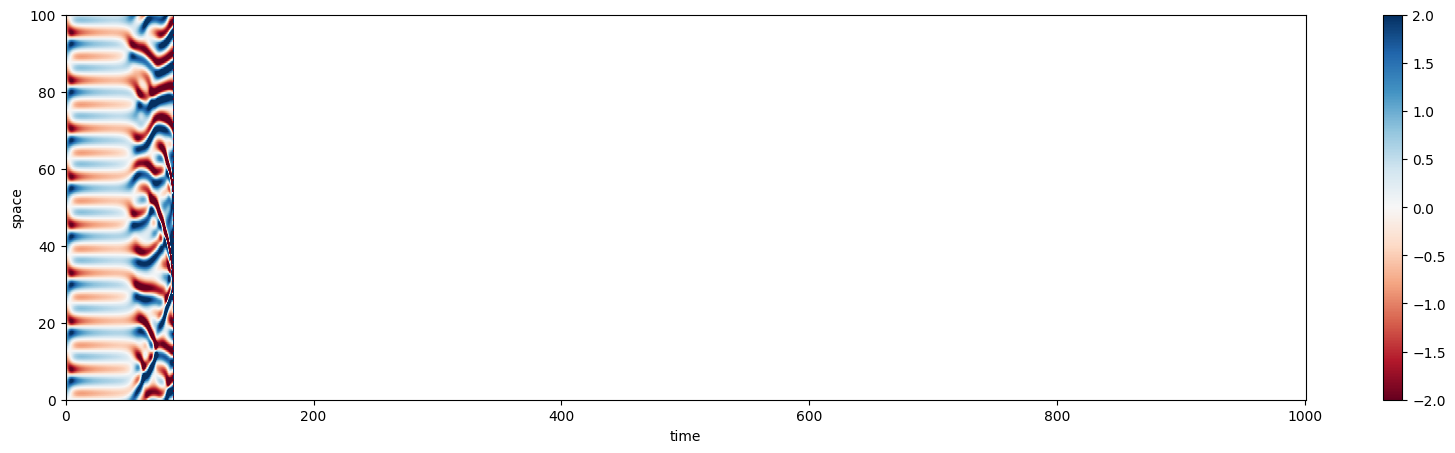

In [10]:
plt.figure(figsize=(20, 5))
plt.imshow(
    trj_etd1.T,
    cmap="RdBu",
    aspect="auto",
    origin="lower",
    extent=(0, trj_etd1.shape[0] * DT, 0, 100),
    vmin=-2,
    vmax=2,
)
plt.colorbar()
plt.xlabel("time")
plt.ylabel("space")

Text(0, 0.5, 'space')

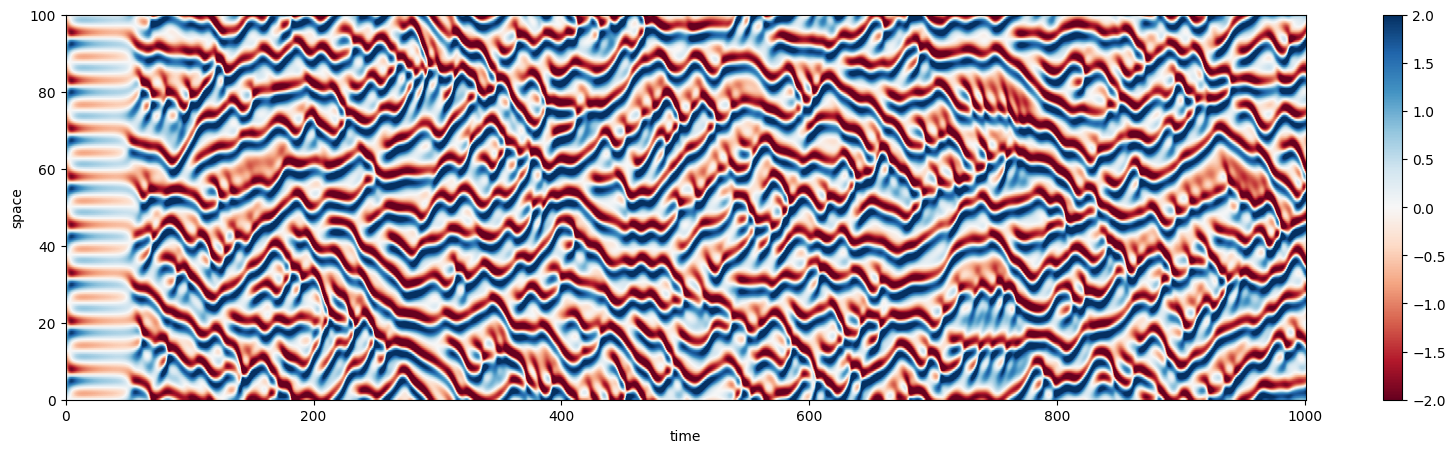

In [11]:
plt.figure(figsize=(20, 5))
plt.imshow(
    trj_etdrk2.T,
    cmap="RdBu",
    aspect="auto",
    origin="lower",
    extent=(0, trj_etdrk2.shape[0] * DT, 0, 100),
    vmin=-2,
    vmax=2,
)
plt.colorbar()
plt.xlabel("time")
plt.ylabel("space")